#  DDPG Crypto-Currency Trading

In [280]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.finance as mpf
from matplotlib.pylab import date2num
from HuobiServices import *
from DataUtils import *
import talib
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
%matplotlib inline

In [281]:
lmap=lambda func,it: list(map(lambda x:func(x),it))
lfilter=lambda func,it: list(filter(lambda x:func(x),it))
z_score=lambda x:(x-np.mean(x,axis=0))/(np.std(x,axis=0)+1e-5)

In [282]:
# assets=['kan','eos','wicc']
assets=assets=['ont', 'kan', 'mana', 'ht']
asset_data=lfilter(lambda x:x[1] is not None,lmap(lambda x:(x,kline(x,interval='15min',count=2000)),assets))
asset_data=lmap(lambda x:(x[0],generate_tech_data(x[1],close_name='close',high_name='high',low_name='low',open_name='open')),asset_data)
asset_data=dict(asset_data)
asset_data=pd.Panel(asset_data)

In [283]:
#####################  hyper parameters  ####################

LR_A = 0.001    # learning rate for actor
LR_C = 0.002    # learning rate for critic
GAMMA = 0.99     # reward discount
TAU = 0.05      # soft replacement
MEMORY_CAPACITY = 100
BATCH_SIZE = 64

###############################  DDPG  ####################################

class DDPG(object):
    def __init__(self, a_dim, s_dim,):
        tf.reset_default_graph()
        self.memory = np.zeros((MEMORY_CAPACITY, s_dim * 2 + a_dim + 1), dtype=np.float32)
        self.pointer = 0
        self.sess = tf.Session()

        self.a_dim, self.s_dim = a_dim, s_dim
        self.S = tf.placeholder(tf.float32, [None, s_dim], 's')
        self.S_ = tf.placeholder(tf.float32, [None, s_dim], 's_')
        self.R = tf.placeholder(tf.float32, [None, 1], 'r')

        with tf.variable_scope('Actor', initializer=tf.contrib.layers.xavier_initializer(uniform=True), regularizer=tf.contrib.layers.l2_regularizer(0.01)):
            self.a = self._build_a(self.S, scope='eval', trainable=True)
            a_ = self._build_a(self.S_, scope='target', trainable=False)
        with tf.variable_scope('Critic', initializer=tf.contrib.layers.xavier_initializer(uniform=True), regularizer=tf.contrib.layers.l2_regularizer(0.01)):
            q = self._build_c(self.S, self.a, scope='eval', trainable=True)
            q_ = self._build_c(self.S_, a_, scope='target', trainable=False)

        self.ae_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Actor/eval')
        self.at_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Actor/target')
        self.ce_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Critic/eval')
        self.ct_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Critic/target')

        self.soft_replace = [[tf.assign(ta, (1 - TAU) * ta + TAU * ea), tf.assign(tc, (1 - TAU) * tc + TAU * ec)]
                             for ta, ea, tc, ec in zip(self.at_params, self.ae_params, self.ct_params, self.ce_params)]

        q_target = self.R + GAMMA * q_
        td_error = tf.losses.mean_squared_error(labels=q_target, predictions=q)
        self.ctrain = tf.train.AdamOptimizer(LR_C).minimize(td_error, var_list=self.ce_params)

        a_loss = - tf.reduce_mean(q)    # maximize the q
        self.atrain = tf.train.AdamOptimizer(LR_A).minimize(a_loss, var_list=self.ae_params)

        self.sess.run(tf.global_variables_initializer())

    def choose_action(self, s):
        return self.sess.run(self.a, {self.S: s})[0]

    def learn(self):
        self.sess.run(self.soft_replace)

        indices = np.random.choice(MEMORY_CAPACITY, size=BATCH_SIZE)
        bt = self.memory[indices, :]
        bs = bt[:, :self.s_dim]
        ba = bt[:, self.s_dim: self.s_dim + self.a_dim]
        br = bt[:, -self.s_dim - 1: -self.s_dim]
        bs_ = bt[:, -self.s_dim:]

        self.sess.run(self.atrain, {self.S: bs})
        self.sess.run(self.ctrain, {self.S: bs, self.a: ba, self.R: br, self.S_: bs_})

    def store_transition(self, s, a, r, s_):
        transition = np.hstack((s, a, [r], s_))
        index = self.pointer % MEMORY_CAPACITY  # replace the old memory with new memory
        self.memory[index, :] = transition
        self.pointer += 1
    def restore_buffer():
        self.memory=np.zeros((MEMORY_CAPACITY, self.s_dim * 2 + self.a_dim + 1), dtype=np.float32)

    def _build_a(self, s, scope, trainable):
        with tf.variable_scope(scope):
            net = tf.layers.dense(s, 64, activation=tf.nn.relu, name='l1', trainable=trainable)
            net = tf.layers.dense(net, 32, activation=tf.nn.relu, name='l2', trainable=trainable)
            a = tf.layers.dense(net, self.a_dim, activation=None, name='a', trainable=trainable)
            a=tf.nn.softmax(a)
            return a

    def _build_c(self, s, a, scope, trainable):
        with tf.variable_scope(scope):
            s=tf.layers.dense(s, 64, activation=tf.nn.relu, name='l1', trainable=trainable)
            n_l1=32
            w1_s = tf.get_variable('w1_s', [64, n_l1], trainable=trainable)
            w1_a = tf.get_variable('w1_a', [self.a_dim, n_l1], trainable=trainable)
            b1 = tf.get_variable('b1', [1, n_l1], trainable=trainable)
            net = tf.nn.relu(tf.matmul(s, w1_s) + tf.matmul(a, w1_a) + b1)
            return tf.layers.dense(net, 1, trainable=trainable)

In [288]:
a_dim=asset_data.shape[0]+1
s_dim=asset_data.shape[0]*asset_data.shape[2]
ddpg = DDPG(a_dim, s_dim)

In [289]:
normalize_length=10
train_length=100
batch_size=10
c=0
epoch=10
train_r=[]
test_r=[]
for e in range(epoch):
    train_reward=[]
    test_reward=[]
    test_actions=[]
    for b in range(batch_size):
        previous_action=np.zeros(a_dim)
        for t in range(b*train_length+normalize_length,(b+1)*train_length+normalize_length):
            state=asset_data[:,t-normalize_length:t,:].values
            next_state=asset_data[:,t-normalize_length+1:t+1,:].values
            state=state.reshape((state.shape[1],state.shape[0]*state.shape[2]))
            next_state=next_state.reshape((next_state.shape[1],next_state.shape[0]*next_state.shape[2]))
            state=z_score(state)[None,-1]
            next_state=z_score(next_state)[None,-1]
            action=ddpg.choose_action(s=state)
            action_index=np.arange(a_dim)
            choice=np.random.choice(action_index,p=action)
            action=np.zeros(a_dim)
            action[choice]=1
            r=np.sum(asset_data[:,:,'diff'].iloc[t].values*action[:-1]-c*np.sum(np.abs(previous_action-action)))
            ddpg.store_transition(state[0], action, r*10, next_state[0])
            if ddpg.pointer > MEMORY_CAPACITY:
                ddpg.learn()
            train_reward.append(r)
            previous_action=action
    print(e,'train_reward',np.sum(train_reward))
    train_r.append(np.sum(train_reward))
    previous_action=np.zeros(a_dim)
    for t in range(train_length*batch_size+normalize_length,asset_data.shape[1]):
        state=asset_data[:,t-normalize_length:t,:].values
        state=state.reshape((state.shape[1],state.shape[0]*state.shape[2]))
        state=z_score(state)[None,-1]
        action=ddpg.choose_action(s=state)
        choice=np.argmax(action)
        action=np.zeros(a_dim)
        action[choice]=1
        r=np.sum(asset_data[:,:,'diff'].iloc[t].values*action[:-1]-c*np.sum(np.abs(previous_action-action)))
        test_reward.append(r)
        test_actions.append(action)
        previous_action=action
    print(e,'test_reward',np.sum(test_reward))
    if np.sum(test_reward)>0.4:
        break
    test_r.append(np.sum(test_reward))

0 train_reward 0.09281150468177657
0 test_reward -0.08830624283928024
1 train_reward 0.3136597614357015
1 test_reward -0.0829905160308042
2 train_reward 0.27076386065346003
2 test_reward -0.05969555222782219
3 train_reward -0.11313040777713479
3 test_reward -0.12399168495016932
4 train_reward 0.2881115411391876
4 test_reward -0.09838680266511823
5 train_reward 0.2980878921448493
5 test_reward 0.026743031943851747
6 train_reward 0.252250435375572
6 test_reward -0.04007243535716076
7 train_reward 0.35176766290669537
7 test_reward -0.05210253625682515
8 train_reward 0.2363294381093507
8 test_reward 0.07095173106063157
9 train_reward 0.12313269023434248
9 test_reward 0.07095173106063157


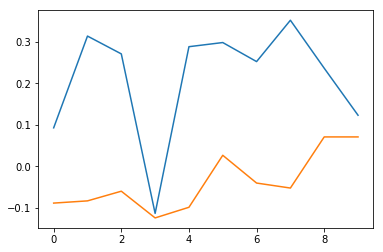

In [290]:
plt.plot(train_r)
plt.plot(test_r)

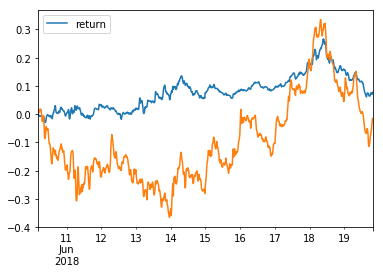

In [291]:
pd.DataFrame(test_reward,index=asset_data[:,train_length*batch_size+normalize_length:,'diff'].index,columns=['return']).cumsum().plot()
asset_data[:,train_length*batch_size+normalize_length:,'diff'].sum(axis=1).cumsum().plot()

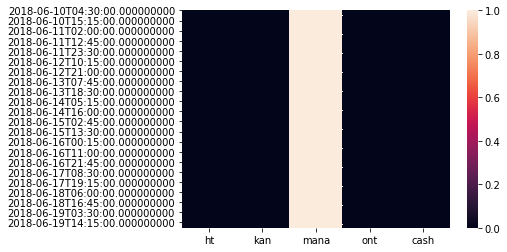

In [292]:
test_action_df=pd.DataFrame(test_actions,index=asset_data[:,train_length*batch_size+normalize_length:,'diff'].index,columns=list(asset_data.items)+['cash'])
sns.heatmap(test_action_df)